### Sources
**Unless otherwise stated, the code in this notebook comes from the material we received from our lecturers during the NLP course of my Masters in Data Science and AI @UAL.** Other sources, or when I wrote the code myself (or modified it), are marked with **##** at the beginning of the corresponding cell.

#### Citation for the Hanover Tagger used in this notebook:
For a explanation of the underlying ideas see: Christian Wartena (2019). A Probabilistic Morphology Model for German Lemmatization. In: Proceedings of the 15th Conference on Natural Language Processing (KONVENS 2019): Long Papers. Pp. 40-49, Erlangen. https://corpora.linguistik.uni-erlangen.de/data/konvens/proceedings/papers/KONVENS2019_paper_10.pdf https://doi.org/10.25968/opus-1527
#### Stopword List from:
https://github.com/solariz/german_stopwords

Marco Götze and Steffen Geyer (2016), Source and more Information: https://solariz.de/de/downloads/6/german-enhanced-stopwords.htm
____


# Bag of Words

In [1]:
#Import all necessary packages
import numpy as np
import pandas as pd 
import re
import nltk
from HanTa import HanoverTagger as ht
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

**Load in the data:**

In [2]:
df = pd.read_csv('data/sorted_manifestos.csv', encoding='utf-8')
#gets rid of a "unnamed" column that just repeats the index
df = df[['manifesto_id','date','party','title','text']]
#show us 3 example rows
df.sample(3)

,manifesto_id,date,party,title,text
44,41420_196509,196509,41420,Ziele des Fortschritts. Aktionsprogramm der Fr...,ZIELE DES FORTSCHRITTS Aktionsprogramm der F...
25,41320_196909,196909,41320,Regierungsprogramm der Sozialdemorkatischen Pa...,Regierungsprogramm der Sozialdemokratischen Pa...
62,41521_195709,195709,41521,An das deutsche Volk. Das Manifest der Christl...,An das deutsche Volk Das Manifest der Christli...


**Load in the stopword list:**

I've edited the original german_stopwords_plain list by adding the letters a-z and the numbers 1-10, as some of them appeared in my results.

In [3]:
## code in this cell is from GeeksForGeeks (2021), 'How to Read Text File Into List in Python?', Example 1
## link: https://www.geeksforgeeks.org/how-to-read-text-file-into-list-in-python/
## modified to read my data and split the text on spaces instead of dots

#open .txt file that contains the stopwords
file_plain = open('stopwords/german_stopwords/german_stopwords_plain_edit.txt', "r")
data_plain = file_plain.read()

#create a list
german_stopwords_plain = data_plain.replace('\n', ' ').split(" ")

**Create my tokeniser:**

For some reason the HanTa function *tagger.tag_sent()*, that I used in the Lemmatiser notebook, didn't work on such a large number of words. However, *tagger.analyze()* does, so I changed my code to use that function.

In [4]:
## I've modified this cell to use my lemmatiser and stopword list + added more symbols to the re.split function

tagger = ht.HanoverTagger('morphmodel_ger.pgz')

def my_tokeniser(doc):
    tokens = re.split(r'[\s.,;!?/"()#»«„“”:&–-]+', doc)
    #remove stopwords
    tokens_sw = [t for t in tokens if not t.lower() in german_stopwords_plain and t != '']
    #lemmatiser
    tags = [tagger.analyze(word) for word in tokens_sw]
    tokens_sw_lemma = [lemma.lower() for (lemma,pos) in tags]
    return tokens_sw_lemma

## Compare the parties with one another
I combined all manifestos of a party in one document. This made it possible to compare the totality of all manifestos of one party with those of the other parties.

In [5]:
## I wrote the code in this cell

#combine the manifestos of every party to one document
partyid_greens = [41111,41112,41113]
partyid_lefts = [41221, 41222, 41223]

document_greens = ''
document_lefts = ''
document_fdp = ''
document_cdu = ''
document_spd = ''
document_dp = ''
document_afd = ''

#loop trough all indices of the dataset
for i in range(len(df)):
    #get the party ID of this index/row
    party_id = df.at[i, 'party']
    #add the text to the corresponding document
    if party_id in partyid_greens:
        document_greens += (' ' + df.at[i, 'text']) 
    elif party_id in partyid_lefts:
        document_lefts += (' ' + df.at[i, 'text'])
    elif party_id == 41420:
        document_fdp += (' ' + df.at[i, 'text'])
    elif party_id == 41521:
        document_cdu += (' ' + df.at[i, 'text'])
    elif party_id == 41320:
        document_spd += (' ' + df.at[i, 'text'])
    elif party_id == 41620:
        document_dp += (' ' + df.at[i, 'text'])
    elif party_id == 41953:
        document_afd += (' ' + df.at[i, 'text']) 
        
documents = [document_afd, document_cdu, document_dp, document_fdp, document_greens, document_lefts, document_spd]
party_names = ['AFD', 'CDU', 'DP', 'FDP', 'Greens', 'Lefts', 'SPD']

In [6]:
#Using the CountVectorizer to get a bag of words using a custom tokeniser
vectoriser = CountVectorizer(tokenizer=my_tokeniser)
vectorised = vectoriser.fit_transform(documents)

In [7]:
## I've modified this cell to print the party names instead of doc numbers/ indices

#Store in a dataframe and sort
num_words = 50
#Use the vocab as the column names
vocab = vectoriser.get_feature_names_out()
data = pd.DataFrame(vectorised.todense(), columns = vocab)
for i in range(len(vectorised.todense())):
    print('party:', party_names[i])
    print(data.iloc[i].sort_values(ascending = False).head(num_words))

party: AFD
für            319
afd             264
deutschland     223
deutsch         213
fordern         149
wollen          118
eu              104
staat            98
familie          91
land             86
kind             85
europäisch       84
stark            77
sozial           70
lehnen           68
jahr             67
staatlich        67
dürfen           61
euro             60
über            59
insbesondere     59
erhalten         58
setzen           58
europa           57
politisch        57
mensch           55
müsse           55
national         51
hoch             51
öffentlich       50
fördern          49
stellen          45
maßnahme         42
bürger          42
neu              41
frei             40
statt            39
bleiben          39
groß             39
partei           38
recht            38
gut              37
beenden          37
stehen           37
sicherheit       36
volk             36
schule           36
wirtschaft       36
gesellschaft     36
ohne     

### Do the same, but use the longer stopword list (german_stopwords full)

In [8]:
## code in this cell is from GeeksForGeeks (2021), 'How to Read Text File Into List in Python?', Example 1
## link: https://www.geeksforgeeks.org/how-to-read-text-file-into-list-in-python/
## modified to read my data and split the text on spaces instead of dots

#open .txt file that contains the longer stopword list
file_full = open('stopwords/german_stopwords/german_stopwords_full_edit.txt', "r")
data_full = file_full.read()

#create a list
german_stopwords_full = data_full.replace('\n', ' ').split(" ")

In [9]:
## I've modified this cell to use my lemmatiser and stopword list + added more symbols to the re.split function

def my_tokeniser_swfull(doc):
    tokens = re.split(r'[\s.,;!?/"()#»«„“”:&–-]+', doc)
    #remove stopwords
    tokens_sw = [t for t in tokens if not t.lower() in german_stopwords_full and t != '']
    #lemmatiser
    tags = [tagger.analyze(word) for word in tokens_sw]
    tokens_sw_lemma = [lemma.lower() for (lemma,pos) in tags]
    return tokens_sw_lemma

In [10]:
#Using the CountVectorizer to get a bag of words
vectoriser_full = CountVectorizer(tokenizer=my_tokeniser_swfull)
vectorised_full = vectoriser_full.fit_transform(documents)

In [11]:
## I've modified this cell to print the party names instead of doc numbers/ indices

#Store in a dataframe and sort
num_words = 50
#Use the vocab as the column names
vocab = vectoriser_full.get_feature_names_out()
data = pd.DataFrame(vectorised_full.todense(), columns = vocab)
for i in range(len(vectorised_full.todense())):
    print('party:', party_names[i])
    print(data.iloc[i].sort_values(ascending = False).head(num_words))

party: AFD
für            319
afd             264
deutschland     223
deutsch         213
eu              104
staat            98
familie          91
land             86
kind             85
europäisch       84
stark            77
sozial           70
lehnen           68
jahr             67
staatlich        67
euro             60
über            59
europa           57
politisch        57
mensch           55
müsse           55
national         51
öffentlich       50
fördern          49
stellen          45
hoch             44
bürger          42
maßnahme         42
groß             39
partei           38
beenden          37
gesellschaft     36
sicherheit       36
wirtschaft       36
schule           36
volk             36
eltern           35
grundgesetz      34
bürger           34
bildung          34
ezb              33
gehören          33
leben            33
politik          32
ausbau           32
verhindern       31
freiheit         31
kultur           30
12               30
schutz   

The longer stop word list actually gives better results because it excludes words that occur frequently but don't say much about the content of the document. For example:
- wollen = to want sth.
- gut = good
- setzen = to set / to place
- brauchen = to need sth.

-> I decided to use this stopword list for my project

### Look at the Cosine Similarity

In [12]:
## I've modified this cell to display the party names instead of indices

#Convert to array 
vector_array = vectorised_full.todense()
#Find similarities
result = cosine_similarity(vector_array)
#Put the result in a dataframe and 
df_result = pd.DataFrame(result)
df_result.columns = party_names
df_result.index = party_names
#Show with heatmap style gradients
df_result.style.background_gradient(cmap='Greens')

/Users/sonja/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,AFD,CDU,DP,FDP,Greens,Lefts,SPD
AFD,1.000000,0.620675,0.444878,0.600098,0.550484,0.526412,0.600526
CDU,0.620675,1.000000,0.527679,0.851807,0.824668,0.733420,0.923295
DP,0.444878,0.527679,1.000000,0.558664,0.438774,0.412152,0.541604
FDP,0.600098,0.851807,0.558664,1.000000,0.804671,0.724097,0.873949
Greens,0.550484,0.824668,0.438774,0.804671,1.000000,0.851304,0.880316
Lefts,0.526412,0.733420,0.412152,0.724097,0.851304,1.000000,0.832222
SPD,0.600526,0.923295,0.541604,0.873949,0.880316,0.832222,1.000000


It is interesting to see that the two right-wing parties DP (manifestos from 1949-1957) and AFD (manifestos since 2013) do not have much in common with the other parties. But these two parties don't seem to have anything in common either.

### Bigrams
It's also interesting to look at Bigrams, as some words seem to appear almost the same amout of time. For example:

    wirtschaft (economy)           429
    unterstützen (support)         424
Are they appearing together or is it a coincidence?

In [13]:
## The code to create n-grams is form course material – I've combined it with the tokeniser.

def my_tokeniser_bigram(doc):
    tokens = re.split(r'[\s.,;!?/"()#»«„“”:&–-]+', doc)
    #remove stopwords
    tokens_sw = [t for t in tokens if not t.lower() in german_stopwords_full and t != '']
    #lemmatiser
    tags = [tagger.analyze(word) for word in tokens_sw]
    tokens_sw_lemma = [lemma.lower() for (lemma,pos) in tags]
    #create n-grams
    n = 2
    ngram_tokens = []
    for i in range(len(tokens_sw_lemma)-n):
        word = tokens_sw_lemma[i]
        for j in range(n - 1):
            word = word + " " + tokens_sw_lemma[i + 1 + j]
        #Add to list
        ngram_tokens.append(word)
    return ngram_tokens

In [14]:
#Using the CountVectorizer to get a bag of words using a custom tokeniser
vectoriser_n = CountVectorizer(tokenizer=my_tokeniser_bigram)
vectorised_n = vectoriser_n.fit_transform(documents)

In [15]:
## I've modified this cell to print the party names instead of indices

#Store in a dataframe and sort
num_words = 50
#Use the vocab as the column names
vocab = vectoriser_n.get_feature_names_out()
data = pd.DataFrame(vectorised_n.todense(), columns = vocab)
for i in range(len(vectorised_n.todense())):
    print('party:', party_names[i])
    print(data.iloc[i].sort_values(ascending = False).head(num_words))

party: AFD
afd für                       17
afd lehnen                     15
deutsch sprache                14
europäisch union               12
bund land                      11
lehnen afd                     11
milliarde euro                 10
für deutschland               10
deutsch interesse              10
afd bekennen                    9
deutsch staatsangehörigkeit     9
voraussetzung für              9
kulturell identität             9
gend ideologie                  9
freiheitlich demokratisch       8
national währung                8
afd treten                      8
national ebene                  8
deutsch unternehmen             8
souverän staat                  8
abs gg                          8
deutsch schule                  8
afd deutsch                     8
vereint nation                  8
sozial marktwirtschaft          7
target forderung                7
beruflich bildung               7
etabliert partei                7
deutsch bundesbank              7
öff

--------
# TF/IDF

In [16]:
#Using the TFIDF Vectorizer to get TFIDF vectors with custom tokeniser
tfidf_vectoriser = TfidfVectorizer(tokenizer=my_tokeniser_swfull)
tfidf = tfidf_vectoriser.fit_transform(documents)
print(tfidf.todense().shape)

(7, 55414)


In [17]:
## I've modified this cell to print the party names instead of indices

vocab = tfidf_vectoriser.get_feature_names()

#Display results
tfidf_df = pd.DataFrame(tfidf.todense(), columns = vocab)
for i in range(len(tfidf_df)):
    print('party:', party_names[i])
    print(tfidf_df.iloc[i].sort_values(ascending = False).head(20))

party: AFD
für           0.681308
afd            0.400062
deutschland    0.199588
deutsch        0.190637
über          0.126010
müsse         0.117467
eu             0.105510
bürger        0.089702
staat          0.087711
familie        0.081446
land           0.076971
kind           0.076076
europäisch     0.075181
stark          0.068916
jahr           0.067973
sozial         0.062651
euro           0.060871
lehnen         0.060861
staatlich      0.059966
politisch      0.051016
Name: 0, dtype: float64
party: CDU
deutschland       0.306870
land              0.248627
stark             0.215016
mensch            0.212944
cdu               0.184753
deutsch           0.167593
csu               0.162311
sozial            0.154241
europäisch        0.143421
europa            0.132141
schaffen          0.122702
jahr              0.122386
groß              0.109810
zukunft           0.107738
fördern           0.103134
politik           0.101983
familie           0.098530
sicherheit     

/Users/sonja/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
## I've modified this cell to display the party names as rows & columns instead of indices

#cosine similarity
result = cosine_similarity(tfidf_df)
#Put the result in a dataframe 
df_result = pd.DataFrame(result)
#name rows & columns
df_result.columns = party_names
df_result.index = party_names
#Show with heatmap style gradients
df_result.style.background_gradient(cmap='Greens')

,AFD,CDU,DP,FDP,Greens,Lefts,SPD
AFD,1.000000,0.412787,0.267180,0.395068,0.370539,0.352596,0.400282
CDU,0.412787,1.000000,0.473275,0.828382,0.811108,0.712199,0.910007
DP,0.267180,0.473275,1.000000,0.499070,0.389191,0.360048,0.485599
FDP,0.395068,0.828382,0.499070,1.000000,0.785392,0.695699,0.852181
Greens,0.370539,0.811108,0.389191,0.785392,1.000000,0.836390,0.869198
Lefts,0.352596,0.712199,0.360048,0.695699,0.836390,1.000000,0.810759
SPD,0.400282,0.910007,0.485599,0.852181,0.869198,0.810759,1.000000


## Compare specific words / topics
> <span style="background-color:lightgray">**##BEGINNING: All following code is written by me, until the END mark** (Unless otherwise stated in the corresponding code cell)</span>

*Info:* I have not included the DP party in the resulting bar charts because it is a party of the past (manifestos from 1949-1957), where the words I have chosen were not really used yet.

### How important (in comparison to the rest of the corpus) are climate-related words?

In [19]:
#rename rows of df into party names
tfidf_df = tfidf_df.set_axis(party_names, axis=0)

In [20]:
#Search for all words containing 'klima' (=climate) to get a feeling for the range of words

#only get the columns
tfidf_columns = tfidf_df.columns
#look for words containing 'klima' in the columns of the df (returns True or False)
klima = tfidf_columns.str.contains(r'klima')
#create a df with all words containing 'klima'
klima_df = tfidf_df.iloc[:, klima]
#print those words
for i in range(len(klima_df.columns)):
    print(klima_df.columns[i])

arbeitsklima
einklimaschutzgesetz
erdklima
friedensklima
gründerklima
innovationsklima
investitionsklima
klima
klimaabkommen
klimaaktivist*inn
klimaallianz
klimaangepasst
klimaanlage
klimaanpassung
klimaanpassungsgesetz
klimaausstoß
klimaaußenbeauftragt
klimaaußenpolitik
klimaaußenpolitisch
klimabedingt
klimabelastung
klimabericht
klimabewegung
klimabewussen
klimabilanz
klimabonus
klimabrücke
klimadiplomatie
klimadividende
klimaeffekt
klimaeffizient
klimaeffizienzreform
klimaemissionsziel
klimaentscheidung
klimaentwicklung
klimaerhitzung
klimaerwärmung
klimafeindlich
klimafinanzierung
klimafinanztransfer
klimaflüchtling
klimafolge
klimafolgenanpassung
klimafonds
klimaforschung
klimafrage
klimafreundlich
klimafreundlichkeit
klimagas
klimagasausstoß
klimageflüchteter
klimageld
klimagerecht
klimagerechtigkeit
klimagipfel
klimahysterie
klimakanzler
klimakatastrophe
klimakatstroph
klimakiller
klimaklage
klimakomponente
klimakonferenz
klimakonvention
klimakooperation
klimakrise
klimakrisenbe

**How often do they talk about the word climate ( = "klima")?**

In [21]:
#look for the TFIDF values for 'klima'
tfidf_df[['klima']]

,klima
AFD,0.013189
CDU,0.008089
DP,0.000000
FDP,0.008249
Greens,0.029430
Lefts,0.012503
SPD,0.007194


**How often do they talk about the climate crisis and similar words?**
- klimawandel = climate change
- klimakrise = climate crisis
- Klimakatastrophe = climate catastrophe
- klimabelastung = climate burden
- klimaproblem = climate problem

In [22]:
klima_df = tfidf_df[['klimawandel', 'klimakrise', 'klimakatastrophe', 'klimabelastung', 'klimaproblem']]
#create the sum out of all values for those words
klima_df = klima_df.sum(axis=1)
#delete the party 'DP' since it is 0
klima_df = klima_df.drop(labels='DP', axis=0)
klima_df

AFD       0.005374
CDU       0.006524
FDP       0.005041
Greens    0.028391
Lefts     0.021722
SPD       0.006946
dtype: float64

In [23]:
## Code in this cell is from the "STEM-Week-3" notebook
## modified to create a bar plot and be inside a function

#create a function to plot outcomes
def barplot(x, title):
    fig, ax = plt.subplots(figsize=(6,4)) 
    ax.set_xlabel('parties')
    ax.set_ylabel('TFIDF value')
    ax.set_xticks(np.arange(6), ['AFD', 'CDU', 'FDP', 'Greens', 'Lefts', 'SPD'])
    plt.title(title, fontsize = 10, pad = 20)
    return ax.bar(np.arange(6),x,align='center')

<BarContainer object of 6 artists>

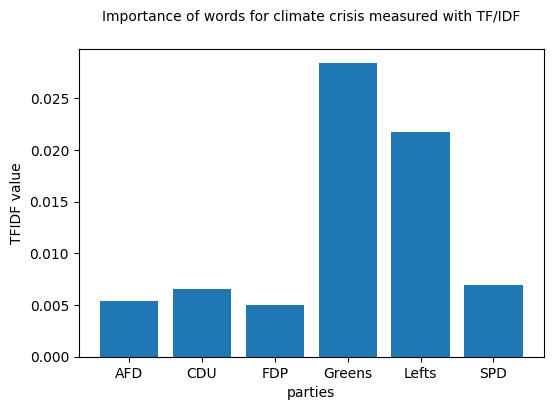

In [24]:
#plot
barplot(np.array(klima_df),'Importance of words for climate crisis measured with TF/IDF' )

**How often do they mention climate protection / action?**

I searched for all words containing 'klimaschutz' (= climate protection). This includes words like 'klimaschutzabkommen' (= climate protection agreement) or 'klimaschutzprojekt'(= climate protection project)

In [25]:
#Search for all words containing 'klimaschutz'
klimaschutz = tfidf_columns.str.contains(r'klimaschutz')
tfidf_df.iloc[:, klimaschutz]

,einklimaschutzgesetz,klimaschutz,klimaschutzabkommen,klimaschutzallianz,klimaschutzaspekt,klimaschutzauflage,klimaschutzfond,klimaschutzfonds,klimaschutzgedank,klimaschutzgesetz,...,klimaschutzprojekt,klimaschutzprozes,klimaschutzstandard,klimaschutzsteuer,klimaschutzstrategi,klimaschutzstrategie,klimaschutztechnologi,klimaschutzvereinbarung,klimaschutzverpflichtung,klimaschutzziel
AFD,0.000000,0.002029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CDU,0.000000,0.013830,0.000296,0.000000,0.000549,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000456,0.000000,0.000456,0.000000,0.000000,0.000000,0.000780,0.000456,0.000456,0.001186
DP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FDP,0.000000,0.010364,0.000240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001478,0.000000,0.000000,0.000445,0.000445,0.000370,0.000000,0.000000,0.000000,0.001682
Greens,0.000402,0.030195,0.000651,0.000402,0.000000,0.000402,0.000402,0.000334,0.000402,0.003425,...,0.000000,0.000402,0.000334,0.000000,0.000000,0.000334,0.000285,0.000000,0.000000,0.001954
Lefts,0.000000,0.014289,0.000676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000520,0.000000,0.001015
SPD,0.000000,0.007691,0.000564,0.000000,0.000000,0.000000,0.000000,0.000434,0.000000,0.000741,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000741,0.000000,0.000434,0.001409


In [26]:
#Calculate the sum for each party
klimaschutz_sum = tfidf_df.iloc[:, klimaschutz].sum(axis=1)
#delete the party 'DP' since it is 0
klimaschutz_sum = klimaschutz_sum.drop(labels='DP', axis=0)
klimaschutz_sum

AFD       0.005487
CDU       0.020951
FDP       0.017176
Greens    0.046860
Lefts     0.020119
SPD       0.015045
dtype: float64

<BarContainer object of 6 artists>

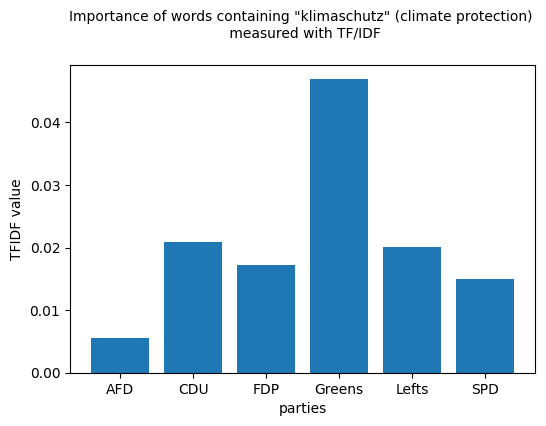

In [27]:
barplot(np.array(klimaschutz_sum),'Importance of words containing "klimaschutz" (climate protection) \n measured with TF/IDF' )

...and 'klimaneutral' (climate neutral), 'klimaneutralität' (climate neutrality)

<BarContainer object of 6 artists>

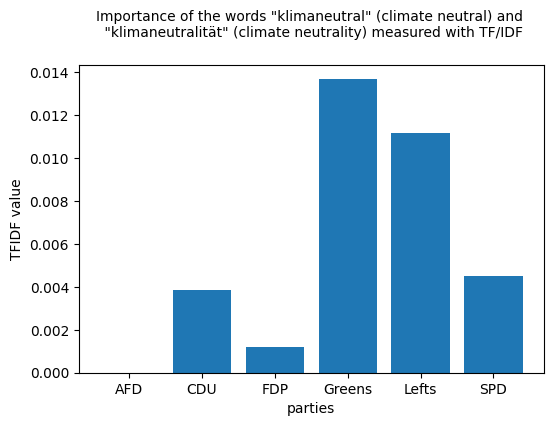

In [28]:
neutral = tfidf_df[['klimaneutral', 'klimaneutralität']]
neutral = neutral.sum(axis=1)
neutral = neutral.drop(labels='DP', axis=0)
barplot(np.array(neutral),'Importance of the words "klimaneutral" (climate neutral) and \n "klimaneutralität" (climate neutrality) measured with TF/IDF' )

**What about power resources?**
- kohle = coal
- atomenergie / atomkraft / kernenergie / kernkraft = nuclear energy
- solar / photovoltaik = solar / photovoltaic
- windkraft = wind power
- wasserkraft = hydropower
- erdgas = gas
- fracking = fracking
- wasserstoff = hydrogen

In [29]:
tfidf_df[['kohle', 'atomenergie', 'atomkraft','kernenergie', 'kernkraft', 'solar', 'photovoltaik', 'windkraft','windenergie', 'wasserkraft', 'erdgas', 'wasserstoff', 'fracking']]

,kohle,atomenergie,atomkraft,kernenergie,kernkraft,solar,photovoltaik,windkraft,windenergie,wasserkraft,erdgas,wasserstoff,fracking
AFD,0.001015,0.000000,0.000000,0.002305,0.000000,0.000000,0.000000,0.000000,0.004058,0.000000,0.001015,0.002029,0.000000
CDU,0.003392,0.000000,0.000000,0.010672,0.001824,0.000000,0.001186,0.001169,0.000783,0.001015,0.000783,0.005480,0.000296
DP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FDP,0.003384,0.000549,0.000000,0.011292,0.000000,0.000823,0.000481,0.000000,0.000635,0.000274,0.000846,0.002115,0.000481
Greens,0.010893,0.004957,0.007993,0.000000,0.000000,0.003222,0.000868,0.001142,0.000573,0.000248,0.003058,0.003440,0.000868
Lefts,0.003572,0.000386,0.004002,0.000676,0.000000,0.000386,0.000676,0.000000,0.000298,0.000000,0.001191,0.002977,0.003382
SPD,0.005210,0.004826,0.004817,0.006482,0.000867,0.000965,0.000564,0.000741,0.000744,0.000322,0.001240,0.002233,0.001127


Create sums of words that mean the same thing (e.g. atomkraft and kernenergie):

In [30]:
atom = tfidf_df[['atomenergie', 'atomkraft','kernenergie', 'kernkraft']]
atom_sum = atom.sum(axis=1)
atom_sum = atom_sum.drop(labels='DP', axis=0)

In [31]:
solar = tfidf_df[['solar','photovoltaik', 'solarenergie']]
solar_sum = solar.sum(axis=1)
solar_sum = solar_sum.drop(labels='DP', axis=0)

In [32]:
wind = tfidf_df[['windkraft', 'windenergie']]
wind_sum = wind.sum(axis=1)
wind_sum = wind_sum.drop(labels='DP', axis=0)

Merge all words back into one df:

In [33]:
energy = tfidf_df[['kohle', 'wasserkraft', 'erdgas', 'wasserstoff', 'fracking']]
energy = energy.drop(labels='DP', axis=0)
#add all columns together
energy = pd.concat([energy, atom_sum, solar_sum, wind_sum], axis=1)
#rename added columns
energy.rename(columns={0: 'atomkraft', 1: 'solarenergie', 2: 'windenergie'}, inplace=True)
#change order of colums
energy = energy.iloc[:,[0,5,2,4,3,1,6,7]]
energy

,kohle,atomkraft,erdgas,fracking,wasserstoff,wasserkraft,solarenergie,windenergie
AFD,0.001015,0.002305,0.001015,0.000000,0.002029,0.000000,0.000000,0.004058
CDU,0.003392,0.012496,0.000783,0.000296,0.005480,0.001015,0.002355,0.001952
FDP,0.003384,0.011841,0.000846,0.000481,0.002115,0.000274,0.001935,0.000635
Greens,0.010893,0.012949,0.003058,0.000868,0.003440,0.000248,0.004376,0.001715
Lefts,0.003572,0.005064,0.001191,0.003382,0.002977,0.000000,0.001062,0.000298
SPD,0.005210,0.016992,0.001240,0.001127,0.002233,0.000322,0.001529,0.001485


Create a plot out of this df:

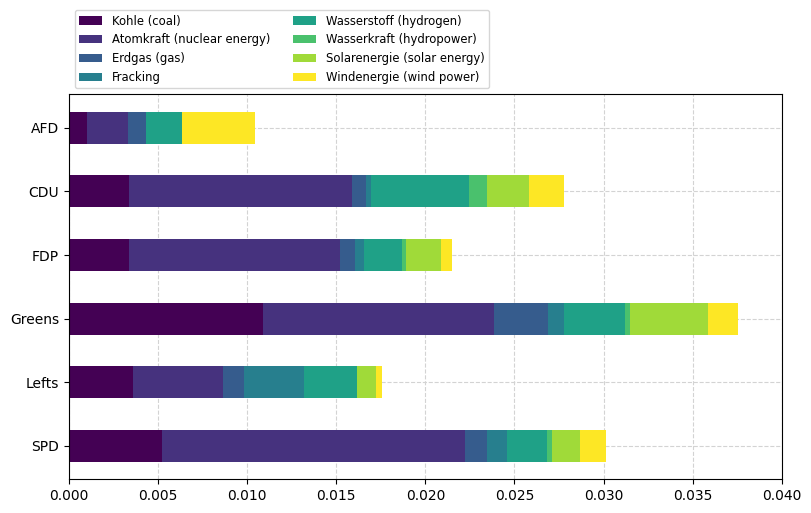

In [34]:
## Code in this cell is from the matplotlib documentation examples, 'Discrete distribution as horizontal bar chart'
## link: https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html
## modified to fit my data + I changed the colors

category_names = ['Kohle (coal)', 'Atomkraft (nuclear energy)', 'Erdgas (gas)', 'Fracking', 'Wasserstoff (hydrogen)', 'Wasserkraft (hydropower)', 'Solarenergie (solar energy)', 'Windenergie (wind power)']
results = {
    'AFD': energy.iloc[0,:],
    'CDU': energy.iloc[1,:],
    'FDP': energy.iloc[2,:],
    'Greens': energy.iloc[3,:],
    'Lefts': energy.iloc[4,:],
    'SPD': energy.iloc[5,:]
}


def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['viridis'](
        np.linspace(0, 1, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0, 0.040)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    ax.xaxis.grid(color='lightgray', linestyle='dashed')

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
    ax.legend(ncol=2, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.grid(True)
plt.show()

### Immigration

For this, I can search for all words containing the stem "einwander" and "zuwander"
- zuwanderung / einwanderung = immigration
- einwandern / zuwandern = immigrate
- Einwanderer / Zuwanderer = immigrant

In [35]:
#Search for all words containing 'einwander' and 'zuwander'
einwander = tfidf_columns.str.contains(r'einwander')
zuwander = tfidf_columns.str.contains(r'zuwander')
#create a df with all words
immigration_df = tfidf_df.iloc[:, einwander + zuwander]
immigration_df

,arbeitskräftezuwanderung,armutszuwanderer,armutszuwanderung,einwander*inn,einwanderer,einwandererfamilie,einwanderergesellschaft,einwandererlnne,einwanderersprache,einwanderin,...,zuwanderungsgesetz,zuwanderungsgruppe,zuwanderungshemmnis,zuwanderungskontingent,zuwanderungspolitik,zuwanderungspolitisch,zuwanderungsproblem,zuwanderungsquote,zuwanderungsrecht,zuwanderungswillig
AFD,0.000000,0.002136,0.000000,0.000000,0.002305,0.000000,0.000000,0.000000,0.002136,0.000000,...,0.000000,0.000000,0.000000,0.002136,0.001316,0.002136,0.000000,0.002136,0.000000,0.000000
CDU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000549,0.000000,0.000000,0.000000,...,0.000889,0.000000,0.000000,0.000000,0.000338,0.000000,0.000000,0.000000,0.000000,0.000549
DP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FDP,0.000000,0.000000,0.000000,0.000000,0.002643,0.000000,0.000000,0.000000,0.000000,0.000823,...,0.000240,0.000445,0.000445,0.000000,0.000274,0.000000,0.000445,0.000000,0.000000,0.000000
Greens,0.000402,0.000000,0.000334,0.000402,0.002822,0.000000,0.000000,0.000402,0.000000,0.002231,...,0.000217,0.000000,0.000000,0.000000,0.000248,0.000000,0.000000,0.000000,0.000334,0.000000
Lefts,0.000000,0.000000,0.000000,0.000000,0.001015,0.000000,0.000000,0.000000,0.000000,0.000386,...,0.000338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SPD,0.000000,0.000000,0.000867,0.000000,0.001691,0.000522,0.000000,0.000000,0.000000,0.000643,...,0.001409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.000000


In [36]:
#Calculate sum
immigration_sum = immigration_df.sum(axis=1)
immigration_sum = immigration_sum.drop(labels='DP', axis=0)
immigration_sum

AFD       0.069385
CDU       0.031835
FDP       0.037751
Greens    0.032687
Lefts     0.014574
SPD       0.024289
dtype: float64

<BarContainer object of 6 artists>

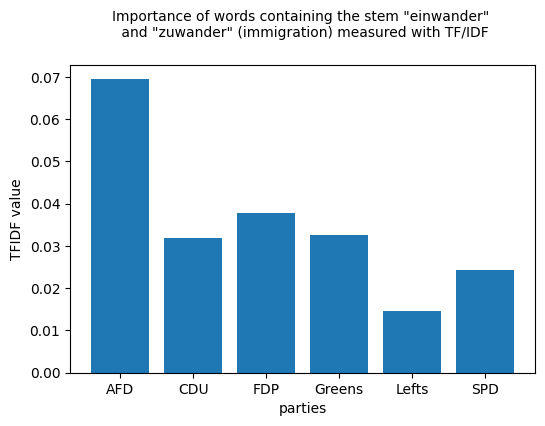

In [37]:
barplot(np.array(immigration_sum),'Importance of words containing the stem "einwander" \n and "zuwander" (immigration) measured with TF/IDF' )

**Do they talk about deportation?**

The same thing applies here, I can use the word stem "abschieb" to also include e.g. "abschieben" (=deport) or "abschiebung" (=deportation).

In [38]:
#Search for all words containing 'abschieb'
abschieb = tfidf_columns.str.contains(r'abschieb')
#create a df with all words
abschieb_df = tfidf_df.iloc[:, abschieb]
abschieb_df

,abschiebbar,abschiebehaft,abschiebehaftplatz,abschiebehindernis,abschiebemoratorium,abschieben,abschiebeoffensiv,abschiebepartnerschaft,abschiebepopulismu,abschiebestopp,abschiebezentre,abschiebung,abschiebungshaft,abschiebungshindernis,abschiebungsstopp,mindestabschiebequot,sammelabschiebung,zur^abschiebung
AFD,0.002136,0.000000,0.000000,0.000000,0.000000,0.003044,0.002136,0.000000,0.000000,0.000000,0.000000,0.013189,0.000000,0.004272,0.000000,0.002136,0.000000,0.000000
CDU,0.000000,0.000338,0.000000,0.000000,0.000000,0.001566,0.000000,0.000000,0.000000,0.000000,0.000000,0.001827,0.000456,0.000000,0.000000,0.000000,0.000456,0.000000
DP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FDP,0.000000,0.000274,0.000445,0.000000,0.000000,0.001269,0.000000,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Greens,0.000000,0.001983,0.000000,0.000402,0.000402,0.003822,0.000000,0.000402,0.000402,0.000805,0.000000,0.005351,0.001002,0.000000,0.000402,0.000000,0.000334,0.000402
Lefts,0.000000,0.001158,0.000000,0.000000,0.000000,0.002382,0.000000,0.000000,0.000000,0.000000,0.001253,0.003572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SPD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<BarContainer object of 6 artists>

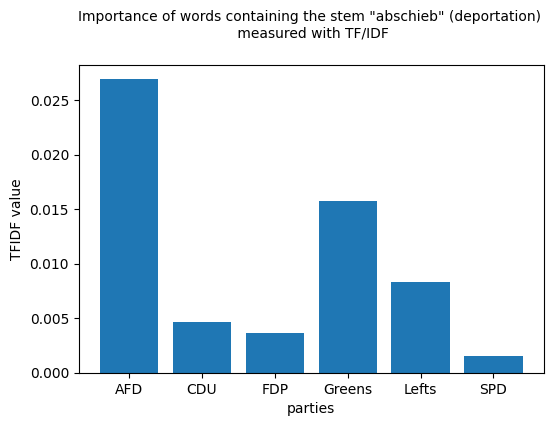

In [39]:
abschieb_sum = abschieb_df.sum(axis=1)
abschieb_sum = abschieb_sum.drop(labels='DP', axis=0)
barplot(np.array(abschieb_sum),'Importance of words containing the stem "abschieb" (deportation) \n measured with TF/IDF' )

**Or about asylum?**
- asyl = asylum
- asylverfahren = asylum procedure
- asylantrag = asylum application

In [40]:
#Search for all words containing 'asyl'
asyl = tfidf_columns.str.contains(r'asyl')
#create a df with all words
asyl_df = tfidf_df.iloc[:, asyl]
#get rid of "kirchenasyl" (church asylum) and "kirchenasylbewegung" (church asylum movement) at the end
asyl_df = asyl_df.iloc[:,0:asyl_df.shape[1]-2]
asyl_df

,asyl,asylagentur,asylanerkennung,asylanerkennungsverfahren,asylanspruch,asylantinn,asylantrag,asylantragsteller,asylantragstellung,asylbegehren,...,asylunterkunft,asylverfahren,asylverfahrensberatung,asylverfahrensgesetz,asylverfahrensgesetze,asylverfahrenspraxis,asylverfahrensprüfung,asylverfahrensrichtlinie,asylverfahrensunabhängige,asylwiderrufsprüfung
AFD,0.012174,0.000000,0.004272,0.000000,0.000000,0.000000,0.002305,0.002136,0.001773,0.000000,...,0.000000,0.003044,0.001515,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
CDU,0.003131,0.000000,0.000000,0.000000,0.000456,0.000000,0.000593,0.000000,0.000000,0.000000,...,0.000000,0.001566,0.000000,0.000390,0.000000,0.000000,0.000000,0.001099,0.00000,0.000000
DP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
FDP,0.003173,0.000000,0.000000,0.000000,0.000370,0.000000,0.001201,0.000000,0.000000,0.000000,...,0.000000,0.001269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00089,0.000000
Greens,0.007262,0.000000,0.000000,0.000402,0.000000,0.000000,0.000651,0.000000,0.000334,0.000402,...,0.000000,0.004587,0.000285,0.000285,0.000805,0.000402,0.000402,0.000000,0.00000,0.000000
Lefts,0.008931,0.000000,0.000000,0.000000,0.000000,0.000627,0.001015,0.000000,0.000000,0.000000,...,0.000627,0.002084,0.000445,0.000445,0.000000,0.000000,0.000000,0.000000,0.00000,0.000627
SPD,0.001985,0.000522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


<BarContainer object of 6 artists>

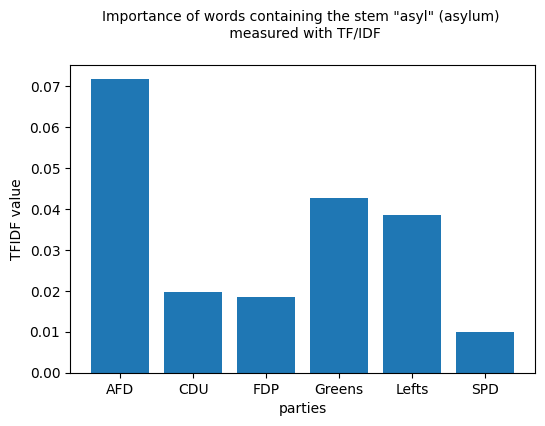

In [41]:
asyl_sum = asyl_df.sum(axis=1)
asyl_sum = asyl_sum.drop(labels='DP', axis=0)
barplot(np.array(asyl_sum),'Importance of words containing the stem "asyl" (asylum) \n measured with TF/IDF' )

### Europe / european
- europa = europe
- europäisch = european

In [42]:
eu = tfidf_df[['europa', 'eu', 'europäisch']]
eu

,europa,eu,europäisch
AFD,0.051016,0.105510,0.075181
CDU,0.132141,0.060541,0.143421
DP,0.042531,0.000000,0.042531
FDP,0.071649,0.108923,0.172032
Greens,0.077047,0.111415,0.132177
Lefts,0.046484,0.092879,0.085614
SPD,0.112932,0.052594,0.145761


<BarContainer object of 6 artists>

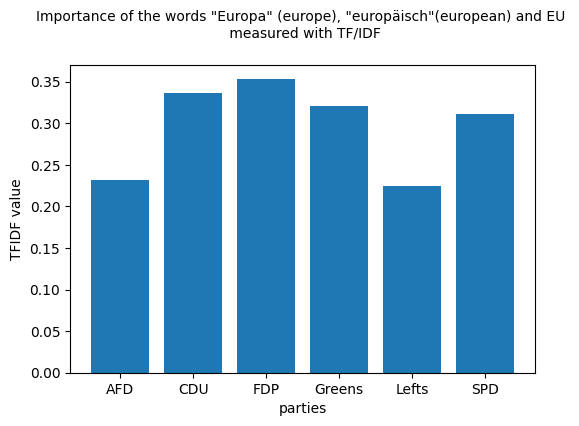

In [43]:
eu_sum = eu.sum(axis=1)
#delete the party 'DP' since it is 0
eu_sum = eu_sum.drop(labels='DP', axis=0)
barplot(np.array(eu_sum),'Importance of the words "Europa" (europe), "europäisch"(european) and EU \n measured with TF/IDF' )

> <span style="background-color:lightgray">**##END: This is the end of the code-block written by me**</span>

## TF/IDF with Bigrams

In [44]:
#Using the TFIDF Vectorizer to get TFIDF vectors with custom tokeniser
tfidf_vectoriser_bi = TfidfVectorizer(tokenizer=my_tokeniser_bigram)
tfidf_bi = tfidf_vectoriser_bi.fit_transform(documents)
print(tfidf_bi.todense().shape)

(7, 542209)


In [45]:
## I've modified this cell to print the party names instead of indices

vocab_bi = tfidf_vectoriser_bi.get_feature_names_out()

#Display results
tfidf_bi_df = pd.DataFrame(tfidf_bi.todense(), columns = vocab_bi)
for i in range(len(tfidf_bi_df)):
    print('party:', party_names[i])
    print(tfidf_bi_df.iloc[i].sort_values(ascending = False).head(50))

party: AFD
afd für                           0.105172
afd lehnen                         0.092799
lehnen afd                         0.068053
für deutschland                   0.061866
afd bekennen                       0.055680
voraussetzung für                 0.055680
gend ideologie                     0.055680
afd treten                         0.049493
afd deutsch                        0.049493
deutsch sprache                    0.046738
target forderung                   0.043306
national währung                   0.041083
corona maßnahme                    0.037120
für mensch                        0.037120
fördern afd                        0.037120
treten für                        0.037120
blue deal                          0.037120
für kind                          0.037120
für deutsch                       0.037120
186 187                            0.037120
europäisch union                   0.035265
souverän staat                     0.035117
entscheidung über   

vgl kapitel                            0.280541
sozial ökologisch                      0.173341
bürgerin bürger                        0.125961
ökologisch umbau                       0.110922
mensch behinderung                     0.109865
linke liste                            0.104935
milliarde euro                         0.094606
liste pds                              0.092086
europäisch union                       0.078329
öffentlich daseinsvorsorge             0.077425
sozial gerechtigkeit                   0.076295
sozial sicherheit                      0.073959
öffentlich hand                        0.073243
bund land                              0.070897
hartz iv                               0.067139
linke treten                           0.064246
linkspartei pds                        0.057821
öffentlich eigentum                    0.057740
linke kämpfen                          0.053538
solidarisch gesundheitsversicherung    0.051397
erneuerbar energie                     0

## Compare how the manifestos of one party change over the years (TF/IDF)
Another possibilitiy to analyse my data is to compare how the manifestos of one single party changed over the years.

In [46]:
## I wrote the code in this cell

#add a column with party names for easier access later on
partynames = []
#loop trough all indices of the dataset
for i in range(len(df)):
    #get the party ID of this index/row
    party_id = df.at[i, 'party']
    #add the corresponding party name
    if party_id in partyid_greens:
        partynames.append('Greens')
    elif party_id in partyid_lefts:
        partynames.append('Lefts')
    elif party_id == 41420:
        partynames.append('FDP')
    elif party_id == 41521:
        partynames.append('CDU')
    elif party_id == 41320:
        partynames.append('SPD')
    elif party_id == 41620:
        partynames.append('DP')
    elif party_id == 41953:
        partynames.append('AFD')

#add column with party names to df
df['partyname'] = partynames

In [47]:
## I've modified this cell by creating a function

# define a function to create TFIDF values & display cosine similarity
def tfidf_parties(data):
    tfidf_vectoriser_party = TfidfVectorizer(tokenizer=my_tokeniser_swfull)
    tfidf_party = tfidf_vectoriser_party.fit_transform(data['text'])
    vocab_party = tfidf_vectoriser_party.get_feature_names_out()
    #Display results
    tfidf_df_party = pd.DataFrame(tfidf_party.todense(), columns = vocab_party)
    for i in range(len(tfidf_df_party)):
        print('date:', data.loc[i]['date'])
        print(tfidf_df_party.iloc[i].sort_values(ascending = False).head(20))
    #cosine similarity
    cosine = cosine_similarity(tfidf_df_party)
    df_cosine = pd.DataFrame(cosine)
    df_cosine.columns = data['date']
    df_cosine.index = data['date']
    return df_cosine.style.background_gradient(cmap='Greens')

In [48]:
## I wrote the code in this cell

#get the rows with 'Greens' and reset the index (otherwise the for loop in tfidf_parties() doesn't work)
greens_df = df.loc[df['partyname'] == 'Greens']
greens_df.reset_index(drop=True, inplace=True)
#get tfidf and cosine similarity
tfidf_parties(greens_df)

date: 198303
sozial            0.179942
land              0.149952
müssen            0.140501
mensch            0.139955
leben             0.129958
ökologisch        0.119961
grune             0.119276
reiten            0.111634
bißchen           0.111634
grün              0.109964
welt              0.109964
bundesrepublik    0.099968
diesmal           0.095421
partei            0.089971
arbeit            0.089971
schrecken         0.083726
wahlaufruf        0.083726
frieden           0.079974
politik           0.079974
kapitalistisch    0.074995
Name: 0, dtype: float64
date: 198701
grün                0.421960
frau                0.310768
mensch              0.191022
sozial              0.168214
bundesrepublik      0.153958
ökologisch          0.139703
müssen              0.132234
leben               0.128299
welt                0.102639
gesellschaft        0.094086
politisch           0.094086
politik             0.091234
kind                0.088383
land                0.079830
gese

date,198303,198701,199012,199410,199809,200209,200509,200909,201309,201709,202109
date,,,,,,,,,,,
198303,1.000000,0.434698,0.424933,0.422478,0.362354,0.332878,0.362070,0.355303,0.355525,0.352859,0.291186
198701,0.434698,1.000000,0.721470,0.640323,0.605797,0.536607,0.552391,0.562445,0.555765,0.545866,0.417837
199012,0.424933,0.721470,1.000000,0.729185,0.657179,0.550092,0.537306,0.539842,0.540810,0.526781,0.424131
199410,0.422478,0.640323,0.729185,1.000000,0.817418,0.664617,0.649998,0.619440,0.634736,0.598461,0.530436
199809,0.362354,0.605797,0.657179,0.817418,1.000000,0.654663,0.639441,0.594188,0.617682,0.579949,0.512839
200209,0.332878,0.536607,0.550092,0.664617,0.654663,1.000000,0.797249,0.729621,0.764893,0.715568,0.689611
200509,0.362070,0.552391,0.537306,0.649998,0.639441,0.797249,1.000000,0.793672,0.825152,0.780523,0.723410
200909,0.355303,0.562445,0.539842,0.619440,0.594188,0.729621,0.793672,1.000000,0.831596,0.798678,0.723000
201309,0.355525,0.555765,0.540810,0.634736,0.617682,0.764893,0.825152,0.831596,1.000000,0.858594,0.814495


- 'ökologisch'(=ecological) appears in the top 20 every year except in 2021
- 'digital' seems to play an important role in the last two manifestos
- 'frau (=woman) also appears almost every year

In [49]:
## I wrote the code in this cell (and the code in the following cells with the same pattern)
# get tfidf values + cosine for the Lefts
lefts_df = df.loc[df['partyname'] == 'Lefts']
lefts_df.reset_index(drop=True, inplace=True)
tfidf_parties(lefts_df)

date: 199012
liste               0.368075
linke               0.305277
ddr                 0.269805
pds                 0.265056
sozial              0.186880
land                0.179252
po                  0.129377
müssen              0.129149
deutschland         0.125858
brd                 0.119006
mensch              0.110602
ökologisch          0.106788
frau                0.099161
bürgerin            0.091533
politisch           0.091533
demokratisch        0.091533
kind                0.087719
öffentlich          0.087719
gesellschaftlich    0.083905
treten              0.080091
Name: 0, dtype: float64
date: 199410
sozial              0.298789
mensch              0.249896
müssen              0.229951
pds                 0.213397
brd                 0.176884
arbeitsplatz        0.135813
frau                0.135813
gesellschaftlich    0.130380
ökologisch          0.130380
kommune             0.114083
entwicklung         0.103218
politisch           0.097785
behinderung         0.

date,199012,199410,199809,200209,200509,200909,201309,201709,202109
date,,,,,,,,,
199012,1.000000,0.552515,0.552537,0.524175,0.433430,0.506445,0.521076,0.497917,0.458388
199410,0.552515,1.000000,0.685265,0.608438,0.551154,0.547916,0.540824,0.549804,0.528163
199809,0.552537,0.685265,1.000000,0.730980,0.622944,0.537728,0.538926,0.534910,0.507596
200209,0.524175,0.608438,0.730980,1.000000,0.680798,0.630002,0.631317,0.626049,0.599376
200509,0.433430,0.551154,0.622944,0.680798,1.000000,0.619958,0.624376,0.615420,0.584897
200909,0.506445,0.547916,0.537728,0.630002,0.619958,1.000000,0.830269,0.799621,0.752397
201309,0.521076,0.540824,0.538926,0.631317,0.624376,0.830269,1.000000,0.884109,0.812411
201709,0.497917,0.549804,0.534910,0.626049,0.615420,0.799621,0.884109,1.000000,0.889159
202109,0.458388,0.528163,0.507596,0.599376,0.584897,0.752397,0.812411,0.889159,1.000000


- Interesting to see that they already used 'Bürgerin' (= femal version of citizen) a lot in 1990, as the movement to always add the female version came up in recent years
- 'sozial' (=social) appears every year
- 'ökologisch' (=ecological) also appears quite often

In [50]:
fdp_df = df.loc[df['partyname'] == 'FDP']
fdp_df.reset_index(drop=True, inplace=True)
tfidf_parties(fdp_df)

date: 194908
heimatvertriebener    0.546524
deutsch               0.212829
partei                0.202921
demokratisch          0.170263
politisch             0.135436
volk                  0.129517
parteitag             0.125395
demontage             0.116717
müssen                0.113203
lastenausgleich       0.091196
ostzone               0.090780
einheimisch           0.084805
land                  0.081262
farbe                 0.077811
entschädigung         0.076462
frei                  0.073051
groß                  0.073051
artikel               0.072421
öffentlich            0.068993
wohnungsbau           0.068906
Name: 0, dtype: float64
date: 195309
fdp                    0.223708
deutsch                0.173640
frei                   0.166936
förderung              0.127345
freiheit               0.115760
ziel                   0.101290
1948                   0.096989
herausheben            0.096989
1953                   0.096989
bundeseigen            0.096989
christlich

date,194908,195309,195709,196109,196509,196909,197211,197610,198010,198303,198701,199012,199410,199809,200209,200509,200909,201309,201709,202109
date,,,,,,,,,,,,,,,,,,,,
194908,1.000000,0.240506,0.269943,0.273518,0.245185,0.229897,0.147817,0.233452,0.277168,0.223748,0.195676,0.262174,0.270949,0.244478,0.225953,0.246058,0.204976,0.222984,0.177038,0.151952
195309,0.240506,1.000000,0.232484,0.267553,0.265848,0.207623,0.114518,0.283939,0.276813,0.243244,0.234862,0.289469,0.257064,0.247341,0.332266,0.314487,0.319017,0.234301,0.169122,0.151556
195709,0.269943,0.232484,1.000000,0.255850,0.235257,0.217756,0.160517,0.245055,0.242410,0.220144,0.202936,0.246195,0.257158,0.240019,0.215388,0.243615,0.199767,0.211332,0.157118,0.129291
196109,0.273518,0.267553,0.255850,1.000000,0.326438,0.332349,0.136687,0.359400,0.396537,0.335181,0.320840,0.377561,0.379774,0.365022,0.285075,0.334035,0.249772,0.292964,0.271405,0.253491
196509,0.245185,0.265848,0.235257,0.326438,1.000000,0.439036,0.147834,0.439417,0.477094,0.382353,0.338310,0.455561,0.483937,0.440553,0.360805,0.424140,0.322016,0.294751,0.242342,0.216989
196909,0.229897,0.207623,0.217756,0.332349,0.439036,1.000000,0.169413,0.502021,0.522497,0.448063,0.425847,0.499122,0.534657,0.514770,0.334109,0.441872,0.298489,0.349543,0.286236,0.247643
197211,0.147817,0.114518,0.160517,0.136687,0.147834,0.169413,1.000000,0.283775,0.249765,0.254884,0.234661,0.240026,0.214045,0.225440,0.180875,0.212532,0.175825,0.237345,0.142813,0.128053
197610,0.233452,0.283939,0.245055,0.359400,0.439417,0.502021,0.283775,1.000000,0.689774,0.610349,0.586904,0.658401,0.652105,0.635874,0.430081,0.559262,0.397000,0.492069,0.338314,0.308610
198010,0.277168,0.276813,0.242410,0.396537,0.477094,0.522497,0.249765,0.689774,1.000000,0.678938,0.627487,0.739717,0.737176,0.691946,0.496629,0.611286,0.463538,0.555092,0.435918,0.397320


- 'einparteienherrschaft' (=One-party rule) has the highest value in 1957 -> Since the CDU alone formed the government
- education seems to be an important topic in 1965, as 'bildungsplanung' and 'bildungsforschung' appear (= Education plan and research)
- 'liberal' scores pretty high from 1972 onwards

Cosine Similarity:
It's different from the other parties that there isn't a bigger block of higher similarity towards recent years

In [51]:
cdu_df = df.loc[df['partyname'] == 'CDU']
cdu_df.reset_index(drop=True, inplace=True)
tfidf_parties(cdu_df)

date: 194908
müssen                 0.255745
sozial                 0.196209
wirtschaft             0.161686
volk                   0.152788
deutsch                0.140149
preis                  0.136666
wirtschaftlich         0.127389
planwirtschaft         0.126289
leistungswettbewerb    0.125134
monopolkontrolle       0.123860
marktwirtschaft        0.112119
marktwirtschaft'       0.109595
verbraucher            0.105053
mittel                 0.102784
kaufkraft              0.096336
ware                   0.096336
fördern                0.087366
markt                  0.084882
betrieb                0.080877
produktion             0.078790
Name: 0, dtype: float64
date: 195309
volk                      0.270450
müssen                    0.266407
christlichdemokratisch    0.233390
deutsch                   0.187259
sozial                    0.180057
union                     0.120859
fördern                   0.110923
mrd                       0.105803
wirtschaft                0.10

date,194908,195309,195709,196109,196509,196909,197211,197610,198010,198303,198701,199012,199410,199809,200209,200509,200909,201309,201709,202109
date,,,,,,,,,,,,,,,,,,,,
194908,1.000000,0.476321,0.204728,0.135189,0.270410,0.362649,0.359607,0.415268,0.338415,0.302378,0.359088,0.362346,0.309727,0.290854,0.296774,0.244693,0.303739,0.283780,0.248454,0.245052
195309,0.476321,1.000000,0.329492,0.279269,0.309929,0.419136,0.396185,0.450205,0.381656,0.342450,0.373352,0.398304,0.319338,0.308584,0.320180,0.268570,0.317655,0.286868,0.264683,0.258409
195709,0.204728,0.329492,1.000000,0.333822,0.279761,0.281201,0.233284,0.336909,0.306771,0.277573,0.211744,0.247505,0.190442,0.167499,0.219494,0.183089,0.215342,0.174855,0.178912,0.152197
196109,0.135189,0.279269,0.333822,1.000000,0.208754,0.185028,0.197792,0.269806,0.241980,0.216658,0.185194,0.207648,0.177473,0.163814,0.194329,0.158238,0.202214,0.185748,0.176520,0.150083
196509,0.270410,0.309929,0.279761,0.208754,1.000000,0.329612,0.325076,0.377876,0.416482,0.398528,0.447680,0.387364,0.507235,0.420954,0.364345,0.317359,0.416888,0.393976,0.378879,0.267478
196909,0.362649,0.419136,0.281201,0.185028,0.329612,1.000000,0.448138,0.465129,0.394912,0.357179,0.410346,0.455182,0.360162,0.357474,0.364593,0.318130,0.361502,0.349933,0.338567,0.322460
197211,0.359607,0.396185,0.233284,0.197792,0.325076,0.448138,1.000000,0.548779,0.468111,0.403698,0.460114,0.449476,0.385042,0.383383,0.378938,0.308387,0.391597,0.373884,0.332317,0.323738
197610,0.415268,0.450205,0.336909,0.269806,0.377876,0.465129,0.548779,1.000000,0.660313,0.548963,0.574487,0.554661,0.457029,0.462634,0.515384,0.430558,0.520469,0.519331,0.463379,0.436876
198010,0.338415,0.381656,0.306771,0.241980,0.416482,0.394912,0.468111,0.660313,1.000000,0.605888,0.566846,0.491720,0.452821,0.443652,0.488387,0.413447,0.488134,0.475482,0.447314,0.379599


- In contrast to the FDP, they use the word 'beständigkeit' (=stability) in 1957
- 'Pandemie' (=Pandemic) scores high in 2021

In [52]:
spd_df = df.loc[df['partyname'] == 'SPD']
spd_df.reset_index(drop=True, inplace=True)
tfidf_parties(spd_df)

date: 194908
deutsch             0.191108
sozialdemokratie    0.184659
kampf               0.144536
alliierter          0.140746
deutschland         0.131386
sozialisierung      0.127002
frankfurter         0.120089
ostzone             0.120089
land                0.119442
flüchtling          0.110323
lüge                0.105560
unbestreitbar       0.105560
volk                0.105117
einheit             0.101277
wirtschaft          0.095554
sozial              0.095554
reich               0.093885
christlich          0.087256
zukunft             0.083610
bodenreform         0.080723
Name: 0, dtype: float64
date: 195309
these                  0.207927
deutschland            0.165446
ausführlich            0.138618
aktionsprogramm        0.136214
unternehmung           0.124237
zeigen                 0.122755
grundstoffindustrie    0.121847
groß                   0.117191
demokratisch           0.115679
partei                 0.115679
sozialdemokratisch     0.108449
müssen            

date,194908,195309,195709,196109,196509,196909,197211,197610,198010,198303,198701,199012,199410,199809,200209,200509,200909,201309,201709,202109
date,,,,,,,,,,,,,,,,,,,,
194908,1.000000,0.268330,0.249477,0.219590,0.257929,0.207718,0.166958,0.234404,0.207835,0.235740,0.226253,0.221010,0.236851,0.214860,0.223477,0.242936,0.235449,0.243231,0.230116,0.183879
195309,0.268330,1.000000,0.314350,0.289070,0.323135,0.267647,0.219178,0.278441,0.259746,0.266060,0.299958,0.264986,0.268663,0.277125,0.269343,0.271183,0.274517,0.288105,0.252632,0.215319
195709,0.249477,0.314350,1.000000,0.377994,0.392264,0.378354,0.282905,0.374552,0.341117,0.338402,0.367835,0.318957,0.353468,0.355550,0.349814,0.349258,0.339449,0.357308,0.323341,0.259432
196109,0.219590,0.289070,0.377994,1.000000,0.473366,0.361285,0.295861,0.339352,0.318588,0.334720,0.386742,0.287783,0.324645,0.347565,0.306160,0.290009,0.280343,0.307722,0.284703,0.238178
196509,0.257929,0.323135,0.392264,0.473366,1.000000,0.449591,0.387152,0.433405,0.430159,0.410967,0.437322,0.391018,0.436337,0.434438,0.420795,0.379670,0.392931,0.429223,0.400743,0.314270
196909,0.207718,0.267647,0.378354,0.361285,0.449591,1.000000,0.407910,0.478593,0.487460,0.444965,0.435599,0.354444,0.437035,0.436605,0.372488,0.354765,0.368745,0.377995,0.348566,0.267583
197211,0.166958,0.219178,0.282905,0.295861,0.387152,0.407910,1.000000,0.572315,0.425289,0.387894,0.399566,0.342509,0.408440,0.380977,0.368977,0.347294,0.378249,0.384140,0.362681,0.282263
197610,0.234404,0.278441,0.374552,0.339352,0.433405,0.478593,0.572315,1.000000,0.526291,0.527600,0.522410,0.408785,0.485199,0.465136,0.467341,0.457201,0.471302,0.475558,0.431080,0.343115
198010,0.207835,0.259746,0.341117,0.318588,0.430159,0.487460,0.425289,0.526291,1.000000,0.569947,0.518334,0.414897,0.535318,0.552172,0.440547,0.426414,0.476435,0.478486,0.445096,0.355783


- 'weltwirtschaftskrise'(=Global economic crisis) appears in 1976
- 'frau' (=woman) appears 1980-1987, 1994 & 2017
- 'cdu' and 'fdp' appear in 2005, but I'm not quite sure why, since they were in the opposition and the SPD & Greens formed the government

In [53]:
dp_df = df.loc[df['partyname'] == 'DP']
dp_df.reset_index(drop=True, inplace=True)
tfidf_parties(dp_df)

date: 194908
ablehnung         0.298737
förderung         0.176439
anerkennung       0.176439
beendigung        0.149368
reich             0.149368
betonung          0.149368
gewährleistung    0.149368
politisch         0.132329
sozial            0.132329
gerecht           0.132329
grundlage         0.132329
sicherung         0.113599
erhaltung         0.113599
echt              0.113599
ehemalig          0.113599
vertriebener      0.113599
krieg             0.113599
freiheit          0.088219
einzeln           0.088219
frei              0.088219
Name: 0, dtype: float64
date: 195309
deutsch               0.271519
müssen                0.194239
volk                  0.174815
politisch             0.165929
wirtschaftlich        0.155391
gesetzgebung          0.153241
grundlage             0.135760
ziel                  0.127701
wirksam               0.116544
deutschland           0.116544
maßnahme              0.116544
mensch                0.102161
frau                  0.102161
europäi

date,194908,195309,195709
date,,,
194908,1.000000,0.212896,0.154488
195309,0.212896,1.000000,0.386105
195709,0.154488,0.386105,1.000000


- 'krieg' (=war) appears in the first two years
- 'europäisch' (=european) appears in 1953

In [54]:
afd_df = df.loc[df['partyname'] == 'AFD']
afd_df.reset_index(drop=True, inplace=True)
tfidf_parties(afd_df)

date: 201309
deutschland    0.264863
euro           0.231755
kind           0.165539
familie        0.132432
politik        0.132432
staat          0.132432
bildung        0.132432
europäisch     0.132432
bür            0.112113
ver            0.112113
rettung        0.112113
partei         0.099324
parlament      0.099324
energie        0.099324
stark          0.099324
demokratie     0.099324
eu             0.099324
achten         0.085265
drastisch      0.085265
grundgesetz    0.066216
Name: 0, dtype: float64
date: 201709
afd            0.439691
deutsch        0.265579
deutschland    0.262418
staat          0.139113
bürger         0.134350
land           0.126466
jahr           0.122136
familie        0.104335
staatlich      0.094850
eu             0.094850
stark          0.094850
mensch         0.093638
kind           0.091688
sozial         0.085495
europa         0.085365
europäisch     0.085365
führen         0.081424
kapitel        0.080297
stellen        0.077353
lehnen        

date,201309,201709,202109
date,,,
201309,1.000000,0.316556,0.196657
201709,0.316556,1.000000,0.509141
202109,0.196657,0.509141,1.000000


- 'kind'(=child) and 'familie' (=family) seem to be important, as they appear every year
- 'deutsch' and/or 'deutschland' (= german / Germany) are  always in the top 5

## Compare the manifestos of one year from all parties

### 2021

In [55]:
## I wrote the code in this cell

#create a df only with the manifestos from 2021
twenty_df = df.loc[df['date'] == 202109]
twenty_df.reset_index(drop=True, inplace=True)

In [56]:
#TFIDF
tfidf_vectoriser_twenty = TfidfVectorizer(tokenizer=my_tokeniser_swfull)
tfidf_twenty = tfidf_vectoriser_twenty.fit_transform(twenty_df['text'])
vocab_twenty = tfidf_vectoriser_twenty.get_feature_names_out()
#Display results
tfidf_df_twenty = pd.DataFrame(tfidf_twenty.todense(), columns = vocab_twenty)
for i in range(len(tfidf_df_twenty)):
    print('party:', twenty_df.loc[i]['partyname'])
    print(tfidf_df_twenty.iloc[i].sort_values(ascending = False).head(20))

party: Greens
stark            0.305743
mensch           0.257518
europäisch       0.207365
eu               0.174572
land             0.153354
deutschland      0.140815
schaffen         0.138886
gemeinsam        0.138886
öffentlich       0.136957
unterstützen     0.130240
sozial           0.125384
fördern          0.116703
kind             0.115739
digital          0.103200
international    0.102236
ermöglichen      0.096449
leben            0.095484
nachhaltig       0.094520
schützen         0.093506
unternehmen      0.090662
Name: 0, dtype: float64
party: Lefts
mensch           0.293021
sozial           0.265721
öffentlich       0.237511
linke            0.224242
vgl              0.168102
stark            0.157431
beschäftigter    0.143780
leben            0.115570
kapitel          0.114960
arbeit           0.109200
jahr             0.108290
land             0.102830
euro             0.101920
schaffen         0.094640
kind             0.090090
ökologisch       0.085540
unternehmen  

In [57]:
#Cosine Similarity
cosine = cosine_similarity(tfidf_df_twenty)
df_cosine = pd.DataFrame(cosine)
df_cosine.columns = twenty_df['partyname']
df_cosine.index = twenty_df['partyname']
df_cosine.style.background_gradient(cmap='Greens')

partyname,Greens,Lefts,SPD,FDP,CDU,AFD
partyname,,,,,,
Greens,1.000000,0.747341,0.815827,0.490090,0.830001,0.258804
Lefts,0.747341,1.000000,0.682455,0.376544,0.609174,0.227568
SPD,0.815827,0.682455,1.000000,0.441101,0.769933,0.235295
FDP,0.490090,0.376544,0.441101,1.000000,0.506589,0.166276
CDU,0.830001,0.609174,0.769933,0.506589,1.000000,0.262809
AFD,0.258804,0.227568,0.235295,0.166276,0.262809,1.000000


-> The AfD doesn't seem to have a lot of similarities with the other parties

**Look up some of the same terms as before (and visualise them)**

In [58]:
## I wrote the code in this cell

#rename rows of df into party names
tfidf_df_twenty = tfidf_df_twenty.set_axis(twenty_df['partyname'], axis=0)

In [59]:
## I wrote the code in this cell

#change order of rows so it's the same as above
tfidf_df_twenty = tfidf_df_twenty.reindex(['AFD', 'CDU', 'FDP', 'Greens', 'Lefts', 'SPD'])

<BarContainer object of 6 artists>

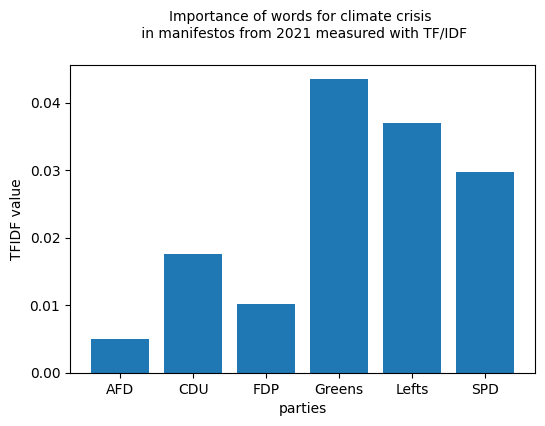

In [60]:
## I wrote the code in this cell

klima_df = tfidf_df_twenty[['klimawandel', 'klimakrise', 'klimakatastrophe']]
#create the sum out of all values for those words
klima_df = klima_df.sum(axis=1)
klima_df
barplot(np.array(klima_df),'Importance of words for climate crisis \n in manifestos from 2021 measured with TF/IDF' )

<BarContainer object of 6 artists>

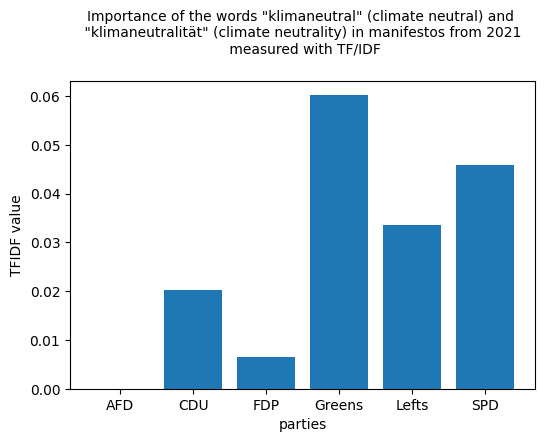

In [61]:
## I wrote the code in this cell

neutral = tfidf_df_twenty[['klimaneutral', 'klimaneutralität']]
neutral = neutral.sum(axis=1)
barplot(np.array(neutral),'Importance of the words "klimaneutral" (climate neutral) and \n "klimaneutralität" (climate neutrality) in manifestos from 2021 \n measured with TF/IDF' )

<BarContainer object of 6 artists>

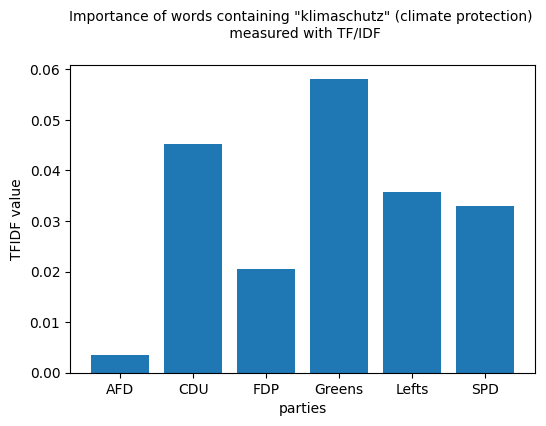

In [62]:
## I wrote the code in this cell

tfidf_twenty_columns = tfidf_df_twenty.columns
klimaschutz = tfidf_twenty_columns.str.contains(r'klimaschutz')
klimaschutz_sum = tfidf_df_twenty.iloc[:, klimaschutz].sum(axis=1)
barplot(np.array(klimaschutz_sum),'Importance of words containing "klimaschutz" (climate protection) \n measured with TF/IDF' )

<BarContainer object of 6 artists>

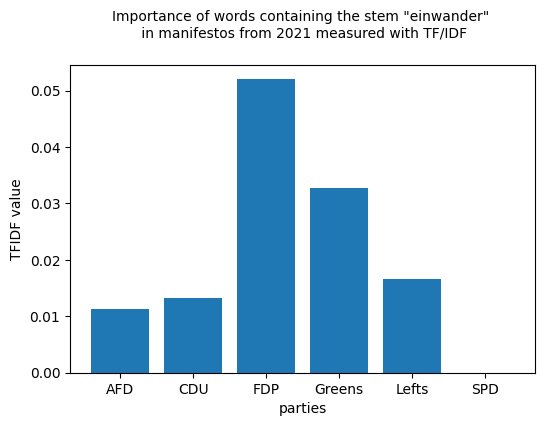

In [63]:
## I wrote the code in this cell

#Search for all words containing 'einwander' - couldn't find words with 'zuwander'
einwander = tfidf_twenty_columns.str.contains(r'einwander')
#create a df with all words
immigration_df = tfidf_df_twenty.iloc[:, einwander]
immigration_sum = immigration_df.sum(axis=1)
barplot(np.array(immigration_sum),'Importance of words containing the stem "einwander" \n in manifestos from 2021 measured with TF/IDF' )

<BarContainer object of 6 artists>

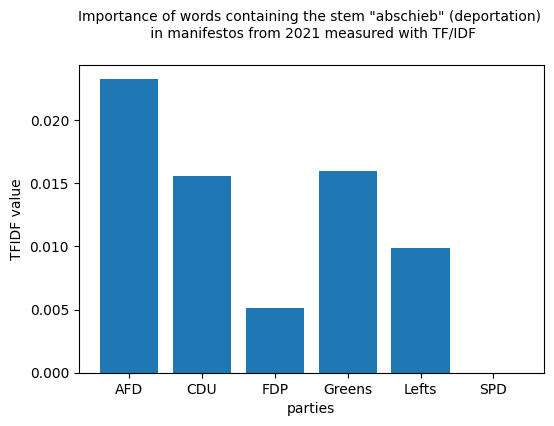

In [64]:
## I wrote the code in this cell

#Search for all words containing 'abschieb'
abschieb = tfidf_twenty_columns.str.contains(r'abschieb')
#create a df with all words
abschieb_df = tfidf_df_twenty.iloc[:, abschieb]
abschieb_sum = abschieb_df.sum(axis=1)
barplot(np.array(abschieb_sum),'Importance of words containing the stem "abschieb" (deportation) \n in manifestos from 2021 measured with TF/IDF' )

### 1990
(After the German reunification)

In [65]:
#get all manifestos from 1990
nineties_df = df.loc[df['date'] == 199012]
nineties_df.reset_index(drop=True, inplace=True)
#TFIDF
tfidf_vectoriser_nineties = TfidfVectorizer(tokenizer=my_tokeniser_swfull)
tfidf_nineties = tfidf_vectoriser_nineties.fit_transform(nineties_df['text'])
vocab_nineties = tfidf_vectoriser_nineties.get_feature_names_out()
#Display results
tfidf_df_nineties = pd.DataFrame(tfidf_nineties.todense(), columns = vocab_nineties)
for i in range(len(tfidf_df_nineties)):
    print('party:', nineties_df.loc[i]['partyname'])
    print(tfidf_df_nineties.iloc[i].sort_values(ascending = False).head(20))

party: Greens
grün                0.478625
frau                0.273339
ökologisch          0.221942
müssen              0.198579
sozial              0.168208
mensch              0.144846
brd                 0.134490
ddr                 0.127060
mann                0.107467
politik             0.105130
gesellschaft        0.105130
politisch           0.091113
welt                0.091113
gesellschaftlich    0.086440
leben               0.084104
dritter             0.074579
international       0.070087
gewalt              0.069054
sexuell             0.068953
land                0.065414
Name: 0, dtype: float64
party: Lefts
liste               0.371173
linke               0.318918
ddr                 0.291020
pds                 0.209170
sozial              0.188453
land                0.180761
brd                 0.149772
deutschland         0.126917
mensch              0.111533
demokratisch        0.109132
ökologisch          0.107687
po                  0.104926
frau                0

The Greens and Lefts use 'brd' (abbreviation for Bundesrepublik Deutschland / Federal Republic of Germany, former west Germany) and ' ddr' (abbrev. for Deutsche Demokratische Republik / former east Germany) a few times. Also, words like 'fördern'/'förderung' (= foster/support) (SPD & FDP) and 'Freiheit' (=freedom) (FDP & CDU) appear.

In [66]:
#Cosine Similarity
cosine = cosine_similarity(tfidf_df_nineties)
df_cosine = pd.DataFrame(cosine)
df_cosine.columns = nineties_df['partyname']
df_cosine.index = nineties_df['partyname']
df_cosine.style.background_gradient(cmap='Greens')

partyname,Greens,Lefts,SPD,FDP,CDU
partyname,,,,,
Greens,1.000000,0.462746,0.427742,0.435983,0.389273
Lefts,0.462746,1.000000,0.414111,0.388090,0.349205
SPD,0.427742,0.414111,1.000000,0.508670,0.571655
FDP,0.435983,0.388090,0.508670,1.000000,0.605279
CDU,0.389273,0.349205,0.571655,0.605279,1.000000


CDU and FDP formed a coalition after that election, so this actually makes sense.

### 1949
(After the end of WW2 in 1945)

In [67]:
#get all manifestos from 1949
forties_df = df.loc[df['date'] == 194908]
forties_df.reset_index(drop=True, inplace=True)
#TFIDF
tfidf_vectoriser_forties = TfidfVectorizer(tokenizer=my_tokeniser_swfull)
tfidf_forties = tfidf_vectoriser_forties.fit_transform(forties_df['text'])
vocab_forties = tfidf_vectoriser_forties.get_feature_names_out()
#Display results
tfidf_df_forties = pd.DataFrame(tfidf_forties.todense(), columns = vocab_forties)
for i in range(len(tfidf_df_forties)):
    print('party:', forties_df.loc[i]['partyname'])
    print(tfidf_df_forties.iloc[i].sort_values(ascending = False).head(20))

party: SPD
sozialdemokratie    0.295613
deutsch             0.224383
deutschland         0.188686
kampf               0.188686
land                0.171533
einheit             0.148314
zukunft             0.148314
volk                0.137226
national            0.134369
sozial              0.112191
wirtschaft          0.112191
wirtschaftlich      0.102920
notwendig           0.102920
groß                0.085766
kirche              0.085766
partei              0.085766
hilfe               0.085766
planung             0.084751
reich               0.084751
alliierter          0.084751
Name: 0, dtype: float64
party: FDP
heimatvertriebener    0.402389
partei                0.280835
deutsch               0.252561
demokratisch          0.247135
volk                  0.162884
politisch             0.160721
müssen                0.129184
land                  0.117951
öffentlich            0.117942
artikel               0.105596
groß                  0.101101
parteitag             0.096796
de

It is interesting that the word ' vertriebener' (=displaced person) (DP) and 'heimatvertriebener'( =expellee) (FDP) appear here.

In [68]:
#Cosine Similarity
cosine = cosine_similarity(tfidf_df_forties)
df_cosine = pd.DataFrame(cosine)
df_cosine.columns = forties_df['partyname']
df_cosine.index = forties_df['partyname']
df_cosine.style.background_gradient(cmap='Greens')

partyname,SPD,FDP,CDU,DP
partyname,,,,
SPD,1.000000,0.328965,0.330415,0.129496
FDP,0.328965,1.000000,0.372539,0.132182
CDU,0.330415,0.372539,1.000000,0.166871
DP,0.129496,0.132182,0.166871,1.000000


This is an interesting result, because the CDU, FDP and DP formed a coalition after this election. However, the DP has very little similairty to the other parties.